In [30]:
import baestorm
import GPy
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswmm_lite import environment
from functools import partial

In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [4]:
means = [0.0]
sigma = np.linspace(2.0, 5.0, 10)
scale = 5.0

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

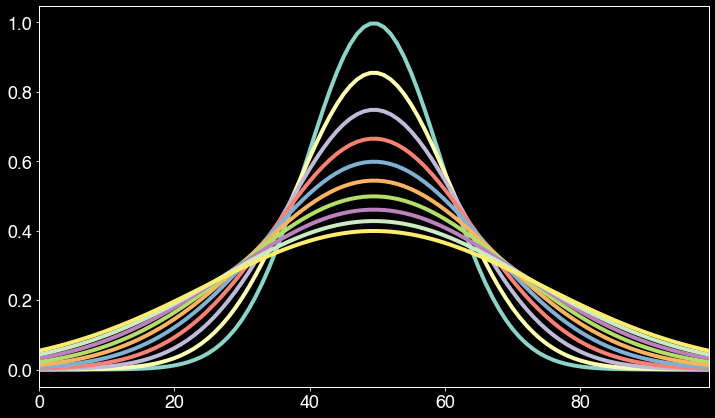

In [5]:
inflows.plot(legend=False)

In [6]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    data["depth"] = []
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))
        data["depth"].append(env._getNodeDepth("P1"))
        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"]), data["depth"]

In [7]:
data_flows = {}
for i in inflows.keys():
    flows, overflow, depth  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

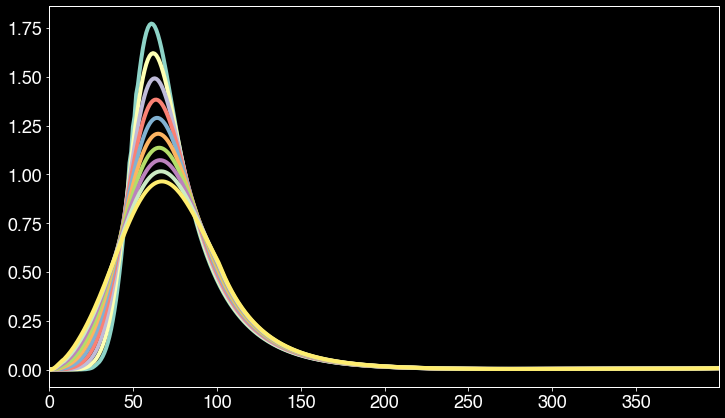

In [8]:
data_flows.plot(legend=False)

In [9]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 9, 10, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows, depth = single_basin(valves, inflows[str(temp_1)].values)
    # If completely closed, then penalize on depth
    reward = 0.0
    threshold=0.50
    reward += depth[-1] * 10.0
    # IF flows exceed threhold, penalize based on the diviation
    flows = pd.Series(flows)
    flows = flows.sub(threshold)
    flows[flows < 0.0] = 0.0
    reward += 10.0*flows.sum()
    # Easire reward 
    #if overflows>0.0:
    #    reward += 30.0*overflows
    return reward

In [10]:
actions = np.linspace(0.0, 1.0, 200)
reward = np.zeros((30, 200))
for action in range(0, 200):
    for rainevent in range(0, 30):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

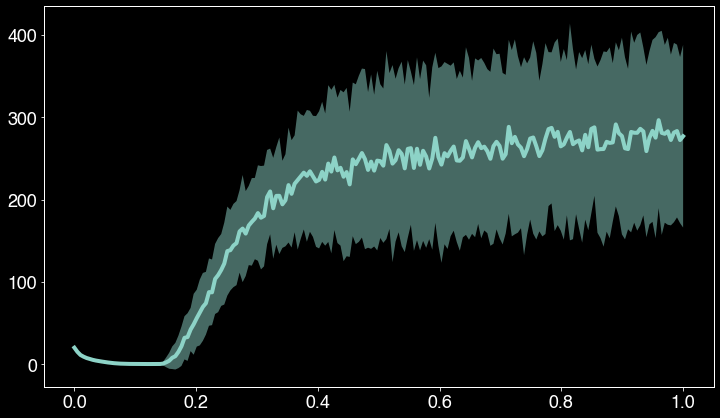

In [11]:
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)

In [12]:
x = []
y = []
val = np.linspace(0.0,1.0,200)
for i in range(0, 200):
    x_t = np.array(np.random.rand()) # random action between 0 to 1
    y_t = objective_function(x_t.reshape(-1,1))
    x.append(x_t)
    y.append(y_t)

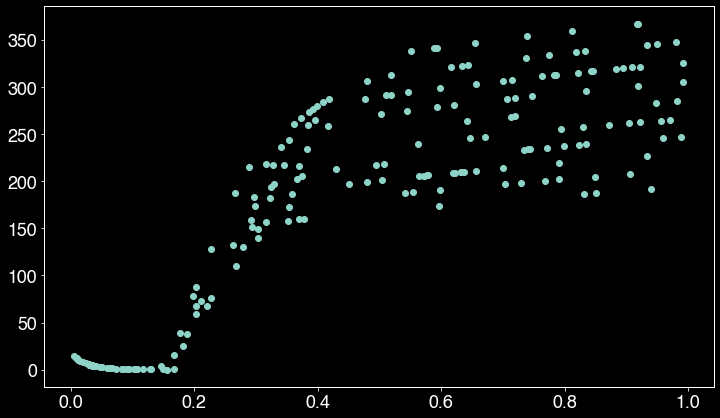

In [13]:
plt.plot(x, y, 'o')

In [14]:
y = np.array(y)
x = np.array(x)

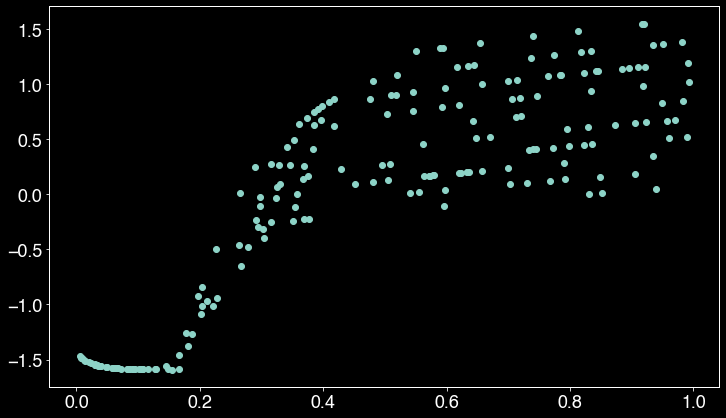

In [15]:
y = (y - y.mean())/y.std()
plt.plot(x, y, 'o')

Optimization restart 1/10, f = 88.53777913734592
Optimization restart 2/10, f = 88.53777913793144
Optimization restart 3/10, f = 88.5377792414454
Optimization restart 4/10, f = 88.53777913734845
Optimization restart 5/10, f = 88.53777913734575
Optimization restart 6/10, f = 88.53777914294679
Optimization restart 7/10, f = 88.53777913746814
Optimization restart 8/10, f = 88.53777913734496
Optimization restart 9/10, f = 88.53777913735875
Optimization restart 10/10, f = 88.53777913735485


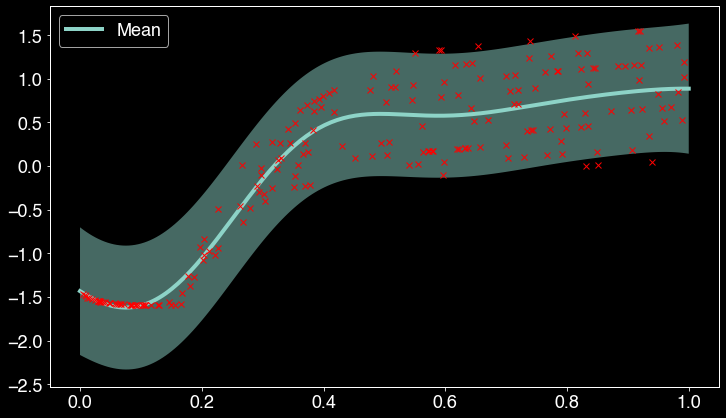

In [16]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)
# Plot error bounds
x_test = np.linspace(0.0,1.0, 200)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
plt.legend()
plt.plot(x,y,'x',color='red')

In [17]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 88.53777913734592
Optimization restart 2/5, f = 88.53777913734726
Optimization restart 3/5, f = 88.5377791374126
Optimization restart 4/5, f = 88.5377791373459
Optimization restart 5/5, f = 88.5377791408014


In [18]:
m, v = gp1.predict(x.reshape(-1,1))
s = 25
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

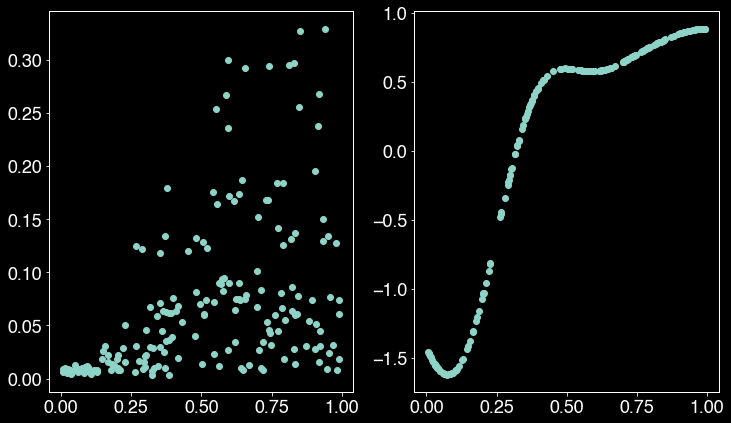

In [19]:
plt.subplot(1,2,1)
plt.plot(x, variance_noise,'o')
plt.subplot(1,2,2)
plt.plot(x, m,'o')

In [20]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/10, f = 259.32723380937443
Optimization restart 2/10, f = 259.327233809664
Optimization restart 3/10, f = 259.3272338111481
Optimization restart 4/10, f = 259.32723380934647
Optimization restart 5/10, f = 259.32723387735575
Optimization restart 6/10, f = 259.3272338254256
Optimization restart 7/10, f = 259.32723381274513
Optimization restart 8/10, f = 259.32723381484567
Optimization restart 9/10, f = 259.32723380944947
Optimization restart 10/10, f = 259.3272345691876


In [21]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -210.78548178793096
Optimization restart 2/10, f = -233.542291719805
Optimization restart 3/10, f = -199.5567863909081
Optimization restart 4/10, f = -202.86397912608857
Optimization restart 5/10, f = -142.16804861694717
Optimization restart 6/10, f = -193.7931160607028
Optimization restart 7/10, f = -213.49055394979996
Optimization restart 8/10, f = -198.96608691011215
Optimization restart 9/10, f = -207.78612496532196
Optimization restart 10/10, f = -192.9310593684943


In [22]:
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

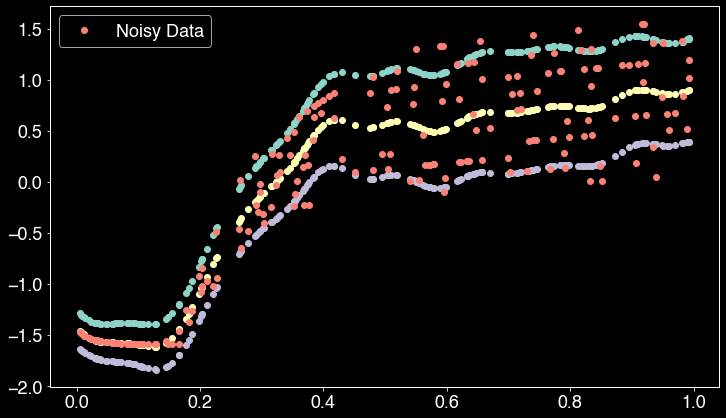

In [23]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, m, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

In [24]:
gp1 = copy.deepcopy(gp3)

## Gaussian Kernel to express the objective function.

In [83]:
def GaussianKernel(x, mu, sigma):
    g = (1/(sigma*np.sqrt(2.0*np.pi))) * np.exp(-0.5*((x-mu)**2/(sigma)))
    return g

In [88]:
GaussianKernel = partial(GaussianKernel, mu=0.5, sigma=0.10)

## Make it a muti-dimentional gaussian

In [90]:
def MutiDimentionalGaussian(flow, overflow):
    g = 1.0 * np.exp(-((flow-0.5)**2.0/(2.0*1.0) +(overflow-0.0)**2.0/(2.0*1.0)))
    return g

In [182]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 9, 10, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows, depth = single_basin(valves, inflows[str(temp_1)].values)
    # If completely closed, then penalize on depth
    reward = 0.0
    threshold=0.50
    # IF flows exceed threhold, penalize based on the diviation
    flows = pd.Series(flows)
    flows_sub = flows.sub(threshold)
    flows_sub[flows_sub < 0.0] = 0.0
    if flows.sum() == 0.0:
        flow_ration = 0.0
    else:
        flow_ration = flows_sub.sum()/flows.sum()
    reward += np.exp(overflows/inflows[str(temp_1)].sum() + flow_ration + depth[-1]/2.0)
    return reward

In [185]:
actions = np.linspace(0.0, 1.0, 100)
reward = np.zeros((10, 100))
for action in range(0, 100):
    for rainevent in range(0, 10):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

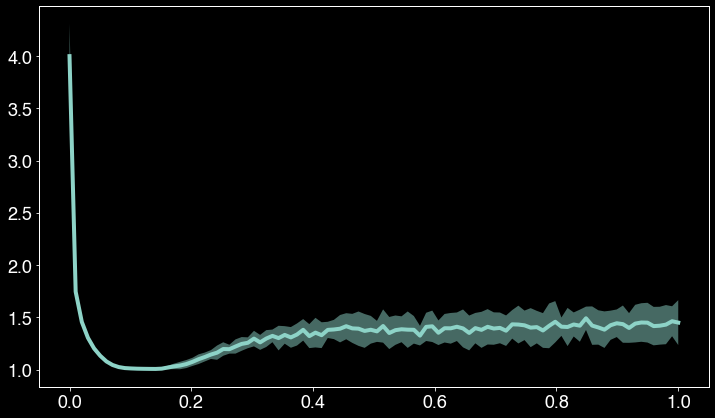

In [186]:
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)

In [187]:
x = []
y = []
val = np.linspace(0.0,1.0,200)
for i in range(0, 200):
    x_t = np.array(np.random.rand()) # random action between 0 to 1
    y_t = objective_function(x_t.reshape(-1,1))
    x.append(x_t)
    y.append(y_t)

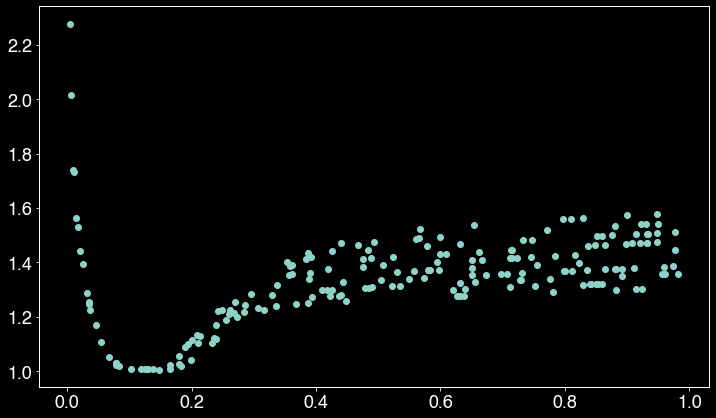

In [188]:
plt.plot(x, y, 'o')

In [189]:
y = np.array(y)
x = np.array(x)

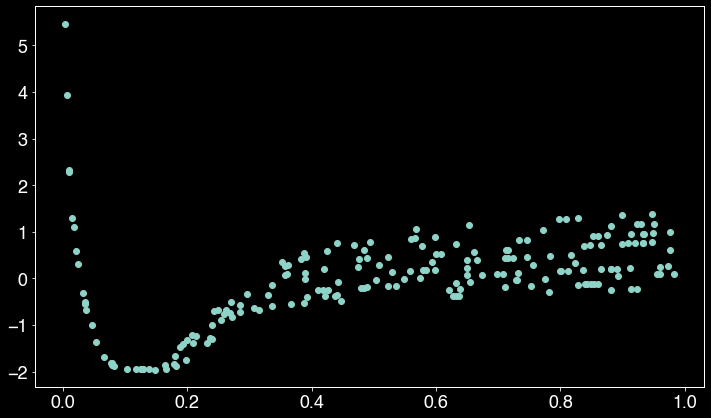

In [190]:
y = (y - y.mean())/y.std()
plt.plot(x, y, 'o')

Optimization restart 1/10, f = 156.59322202339172
Optimization restart 2/10, f = 156.59322202153527
Optimization restart 3/10, f = 156.59322202162798
Optimization restart 4/10, f = 156.59322202160183
Optimization restart 5/10, f = 156.59322202193795
Optimization restart 6/10, f = 156.5932220216733
Optimization restart 7/10, f = 156.59322202166578
Optimization restart 8/10, f = 156.5932220216266
Optimization restart 9/10, f = 156.59322202155386
Optimization restart 10/10, f = 156.59322202153552


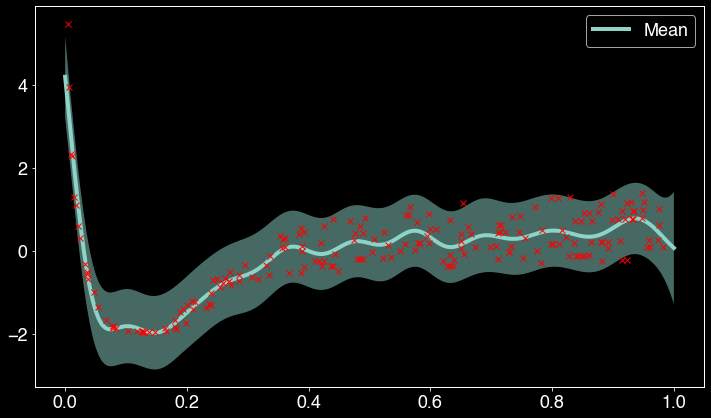

In [191]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)
# Plot error bounds
x_test = np.linspace(0.0,1.0, 200)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
plt.legend()
plt.plot(x,y,'x',color='red')

In [192]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 156.59322202339172
Optimization restart 2/5, f = 156.59322202158305
Optimization restart 3/5, f = 156.59322202935294
Optimization restart 4/5, f = 156.59322202239895
Optimization restart 5/5, f = 156.5932220251712


In [203]:
m, v = gp1.predict(x.reshape(-1,1))
s = 25
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

In [204]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/10, f = 360.4050802465577
Optimization restart 2/10, f = 360.4050802538911
Optimization restart 3/10, f = 360.40508024659175
Optimization restart 4/10, f = 360.4050802469774
Optimization restart 5/10, f = 360.4050802474386
Optimization restart 6/10, f = 360.40508024663666
Optimization restart 7/10, f = 360.4050802676245
Optimization restart 8/10, f = 360.4050802476916
Optimization restart 9/10, f = 360.4050802465569
Optimization restart 10/10, f = 360.40508024661347


In [205]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -32.01698892113157
Optimization restart 2/10, f = -43.70442934211533
Optimization restart 3/10, f = -39.323055432958455
Optimization restart 4/10, f = -43.13342593443983
Optimization restart 5/10, f = -41.358706974734304
Optimization restart 6/10, f = -40.00777714551313
Optimization restart 7/10, f = -47.07205696194373
Optimization restart 8/10, f = -18.6698603624599
Optimization restart 9/10, f = -46.098481364610535
Optimization restart 10/10, f = -9.66855363878338


In [206]:
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

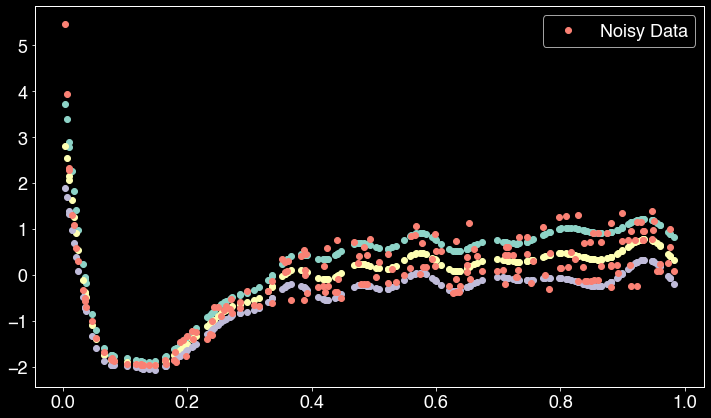

In [207]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, m, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

In [202]:
gp1 = copy.deepcopy(gp3)

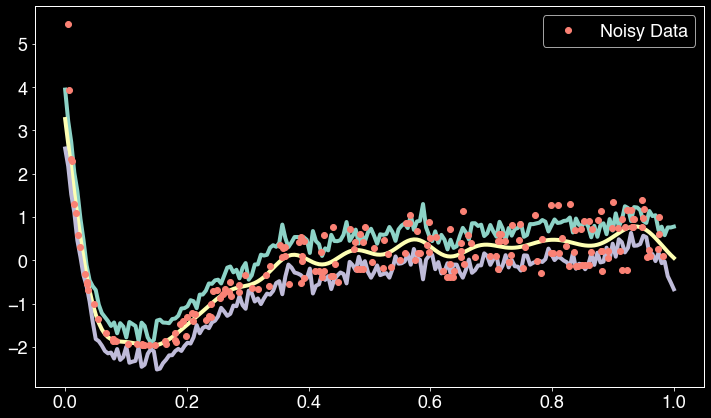

In [208]:
x_t = np.linspace(0.0, 1.0, 200)
m, v = gp3.predict(x_t.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x_t, up)
plt.plot(x_t, m)
plt.plot(x_t, dwn)
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()